In [505]:
# cub200 model: checkpoint/cub200/base_mixup_contrastive_sr/baseline6.0-mixup-joint_label_smoothing_test+1024_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.78.pth
# minet model: checkpoint/mini_imagenet/base_supcon_multi/sup_con_best+9_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.69.pth

In [642]:
import importlib

from dataloader.data_utils import *

import torch
import torch.nn as nn
import utils

# Load default args
import pickle
file = open("default_args.obj",'rb')
args = pickle.load(file)
file.close()

args.gpu = "2"
args.num_gpu = utils.set_gpu(args)

use gpu: [2]


In [643]:
from PIL import Image

from tqdm import tqdm

import umap

from sklearn.neighbors import KNeighborsClassifier

from copy import deepcopy

# calculating the pairwise distance between each prototype
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [650]:
def vis_umap(embedding_list, labels_list, datalist=None):
    data = umap.UMAP(n_components=2).fit_transform(embedding_list.cpu())
    num_classes = len(torch.unique(labels_list))
    # passing to dataframe
    df = pd.DataFrame()
    df["feat_1"] = data[:, 0]
    df["feat_2"] = data[:, 1]
    df["Y"] = labels_list.cpu()
    plt.figure(figsize=(9, 9))
    ax = sns.scatterplot(
        x="feat_1",
        y="feat_2",
        hue="Y",
        palette=sns.color_palette("hls", num_classes),
        data=df,
        legend="full",
        alpha=0.3,
    )
        
    ax.set(xlabel="", ylabel="", xticklabels=[], yticklabels=[])
    ax.tick_params(left=False, right=False, bottom=False, top=False)
    if num_classes > 100:
        anchor = (0.5, 1.8)
    else:
        anchor = (0.5, 1.35)
        
    plt.legend(loc="upper center", bbox_to_anchor=anchor, ncol=math.ceil(num_classes / 10))
    plt.tight_layout()

In [651]:
def load_model(model, model_dir):
    if model_dir is not None:
        best_model_dict = {}
        if model_dir.endswith(".ckpt"):
            solo_dict = torch.load(model_dir)["state_dict"]
            for k,v in solo_dict.items():
                if "backbone" in k:
                    best_model_dict[k.replace("backbone", "module.encoder")] = v
        else:
            print('Loading init parameters from: %s' % model_dir)
            best_model_dict = torch.load(model_dir)['params']
                    
    return best_model_dict

def compute_average_cosine_sim(best_prototypes):
    sim = cosine_similarity(best_prototypes.cpu(), best_prototypes.cpu())
    mask = np.ones_like(sim, dtype=bool)
    np.fill_diagonal(mask, 0)
    average_proto_sim = sim[mask].mean()
    print(f"Average prototype cosine similarity: {average_proto_sim}")
    
def test(model, fc, base_testloader):
    # test model using the base test set
    _, va, _, _, _, _ = model.module.test_fc(fc, base_testloader, 0, 0)
    print("Base Class Validation Accuracy = ", va)

def loader_to_embeddings(model, loader):
    embedding_list = []
    label_list = []
    og_mode = model.module.mode
    with torch.no_grad():
        tqdm_gen = tqdm(loader)
        tqdm_gen.set_description("Computing Embeddings: ")
        for i, batch in enumerate(tqdm_gen, 1):
            data, label = [_.cuda() for _ in batch]
            model.module.mode = 'encoder'
            embedding = model(data)
            embedding_list.append(embedding)
            label_list.append(label)
    
    model.module.mode = og_mode
    embedding_list = torch.cat(embedding_list, dim=0)
    label_list = torch.cat(label_list, dim=0)

    return embedding_list, label_list

def compute_knn_score(embedding, labels, model, base_testloader):
    # Compute knn score for the backbone. 
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(embedding.cpu(), labels.cpu())
    val_embedding, val_labels = loader_to_embeddings(model, base_testloader)
    score = neigh.score(val_embedding.cpu(), val_labels.cpu())
    print(f"Base Class Validation Accuracy usign KNN: {score*100:.3f}")

def finetune_prototypes(prototypes, trainloader):
    # freeze backbone
    
    
    # prototype to classifier of the model. This prototype could no potentially be multiple things
    # it could be the average of the train embeddings
    # cluster centroids from KNN
    # weighted embedding
    # randomly intialised
    model.module.fc.classifiers[0].weight.data = prototypes
    
    # using cross entropy we now fine tune the base classifier and observe the accuracy after each epoch
    model.module.finetune_head(trainloader)

## MINET

In [515]:
args.incremental_on_supcon_head = False

In [498]:
MYNET = importlib.import_module('models.%s.Network' % ("base_supcon_multi_alice")).MYNET
helper = importlib.import_module('models.%s.helper' % ("base_supcon_multi_alice"))

args = set_up_datasets(args)

model = MYNET(args, mode=args.base_mode, writer = None)
model = nn.DataParallel(model, list(range(args.num_gpu)))
model = model.cuda()

# minet_model_dir = "checkpoint/mini_imagenet/base_supcon_multi/sup_con_best+9_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.69.pth"
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/wjmosi0f/supcon-minet-wjmosi0f-ep=348.ckpt"
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/di0eby6u/supcon-minet-di0eby6u-ep=399.ckpt" 
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/v51k3xhi/supcon-minet-v51k3xhi-ep=399.ckpt" # with margin
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/simclr/h9gcql49/simclr-minet-h9gcql49-ep=399.ckpt" # simclr
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/5x6o17nk/supcon-minet-5x6o17nk-ep=399.ckpt"
# minet_model_dir = "/BS/fscil/work/code/CEC-CVPR2021/checkpoint/mini_imagenet/base_supcon_multi/sup_con_high_feat_dim_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.63.pth" # With mixup
# minet_model_dir = "/BS/fscil/work/code/CEC-CVPR2021/checkpoint/mini_imagenet/base_supcon_multi_alice/sup_con_with_alice_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.81.pth"
# minet_model_dir = "checkpoint/mini_imagenet/base_supcon_multi_alice/test/session_pretrain.ckpt"
# minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/92cgmk51/supcon-minet-92cgmk51-ep=371 copy.ckpt"
minet_model_dir = "/BS/fscil/work/code/solo-learn/trained_models/supcon/6lj5gwje/supcon-minet-6lj5gwje-ep=399.ckpt"
best_model_dict = load_model(model, minet_model_dir)

base_set, base_trainloader, base_testloader = get_base_dataloader(args)

In [499]:
load_strict = not minet_model_dir.endswith(".ckpt") if minet_model_dir is not None else True
model.load_state_dict(best_model_dict, strict = load_strict)

_IncompatibleKeys(missing_keys=['module.sup_con_head.weight', 'module.sup_con_head.bias', 'module.fc.base_fc.weight', 'module.fc.classifiers.0.weight'], unexpected_keys=[])

In [500]:
# Get prototypes
out = helper.get_base_fc(base_set, base_testloader.dataset.transform, model, args, return_embeddings=True)

best_prototypes_minet = out[0]
embedding_list = out[1]
labels_list = out[2]

Generating Features: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:33<00:00,  6.98it/s]


In [461]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.001s...
[t-SNE] Computed neighbors for 60 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.394319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.189026
[t-SNE] KL divergence after 300 iterations: 0.158649


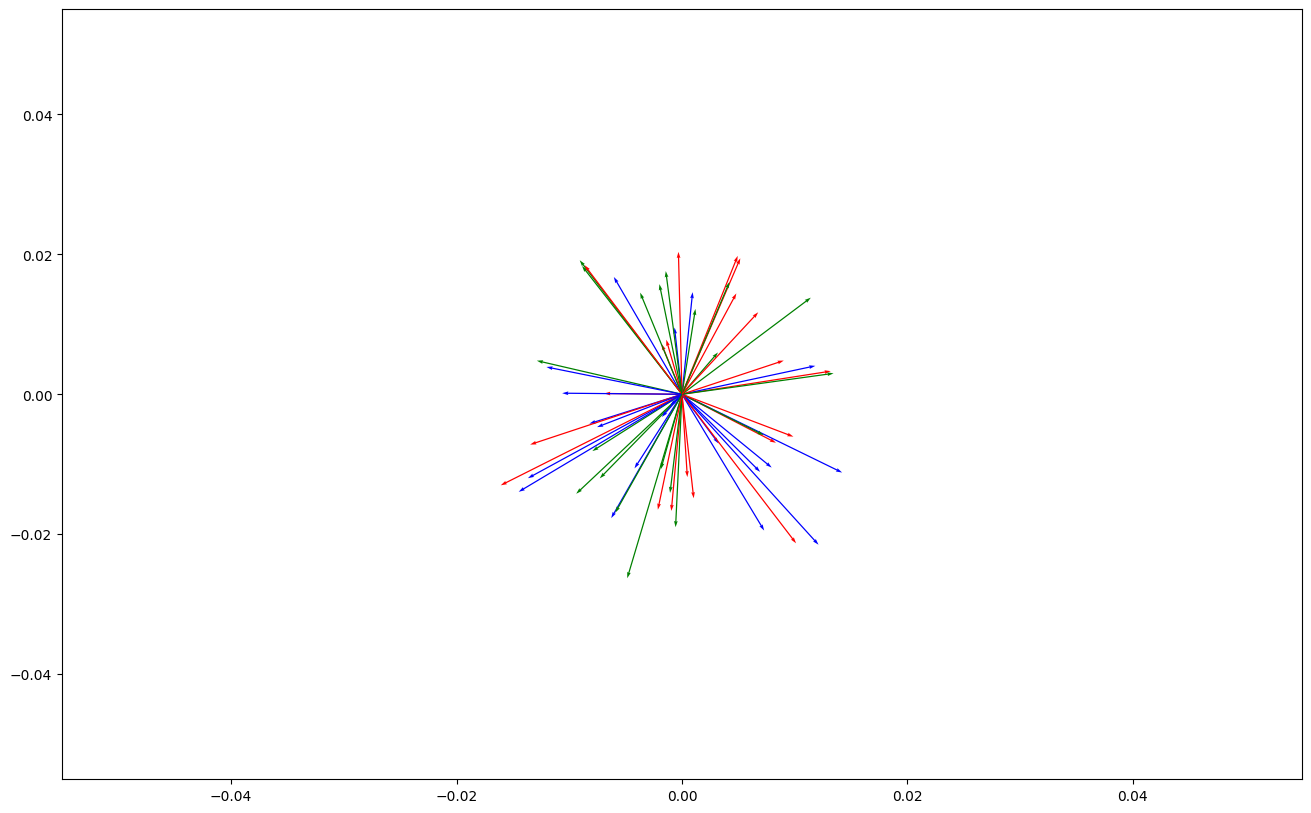

In [276]:
def vis_prototypes(prototypes):
    X = prototypes.cpu()
    y = np.arange(prototypes.shape[0])
    feat_cols = [ 'feature'+str(i) for i in range(X.shape[1])]    
    df = pd.DataFrame(X,columns=feat_cols)
    
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))
    num_classes = y.shape[0]
    X, y = None, None
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])
    
    df_subset = df.loc[rndperm,:].copy()
    data_subset = df_subset[feat_cols].values
    
#     pca = PCA(n_components=3)
#     tsne_results = pca.fit_transform(data_subset)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
#     df_subset['tsne-2d-three'] = tsne_results[:,2]
    
    fig = plt.figure(figsize=(16,10))
#     sns.scatterplot(
#         x="tsne-2d-one", y="tsne-2d-two",
#         hue="y",
#         palette=sns.color_palette("hls", 10),
#         data=df_subset,
#         legend="full",
#         alpha=1
#     )
#     ax = fig.add_subplot(111, projection = '3d')
#     ax = Axes3D(fig)
#     x = df_subset['tsne-2d-one']
#     y = df_subset['tsne-2d-two']
#     z = df_subset['tsne-2d-three']
#     ax.scatter(x, y, z)
    
#     if num_classes > 100:
#         anchor = (0.5, 1.8)
#     else:
#         anchor = (0.5, 1.35)
#     plt.legend(loc="upper center", bbox_to_anchor=anchor, ncol=math.ceil(num_classes / 10))
#     plt.tight_layout()

    origin = np.zeros((2,num_classes))
    plt.quiver(*origin, df_subset["tsne-2d-one"], df_subset["tsne-2d-two"], color=['r','b','g'], scale=15, width=0.001)
    plt.show()

vis_prototypes(best_prototypes_minet)

In [501]:
compute_average_cosine_sim(best_prototypes_minet)

Average prototype cosine similarity: 0.6233704686164856


In [470]:
test(model, best_prototypes_minet, base_testloader)

  0%|                                                                                                                                                                                                                                         | 0/60 [00:02<?, ?it/s]


NameError: name 'count_acc_binary' is not defined

In [502]:
compute_knn_score(embedding_list, labels_list, model, base_testloader)

Computing Embeddings: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.76it/s]


Base Class Validation Accuracy usign KNN: 72.233


In [11]:
finetune_prototypes(best_prototypes_minet, base_trainloader)

Loss at the beginning of training: 1.8490653038024902


Loss: 0.657: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:17<00:00, 18.18s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.01it/s]


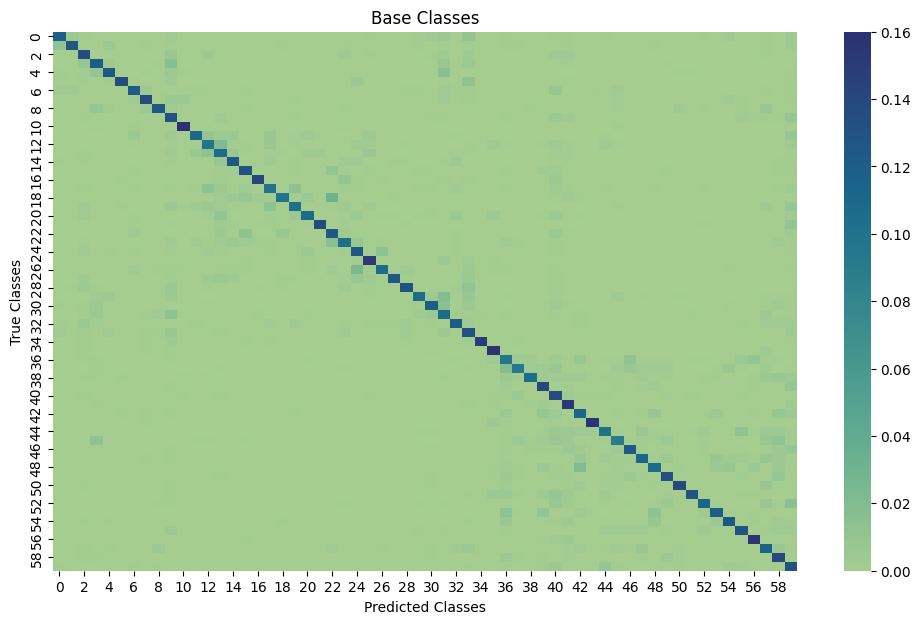

In [503]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix

# for the validation set
def make_confusion_matrix(base_testloader, model, best_prototypes):
    label_list = []
    predictions = []
    with torch.no_grad():
        tqdm_gen = tqdm(base_testloader)
        for i, batch in enumerate(tqdm_gen, 1):
            data, label = [_.cuda() for _ in batch]
            model.module.mode = 'encoder'
            embedding = model(data).detach()
            
            logits = model.module.get_logits(embedding, best_prototypes)
            pred = torch.argmax(logits, axis = 1)
            
            predictions.append(pred)
            label_list.append(label)
    
    predictions = torch.cat(predictions, dim = 0).cpu()
    label_list = torch.cat(label_list, dim = 0).cpu()
    
    cf_matrix = confusion_matrix(label_list, predictions)
    
    classes = label_list.unique().numpy()

    # Visualize confusion matrix
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    
    plt.figure(figsize=(12, 7))    
    heatmap = sns.heatmap(df_cm, annot=False, cmap = "crest")

    heatmap.set(xlabel="Predicted Classes", ylabel="True Classes", title=f"Base Classes")
    
    return cf_matrix

cm = make_confusion_matrix(base_testloader, model, best_prototypes_minet)

In [94]:
import numpy as np

In [279]:
def print_most_confused_classes(cm):
    mask = np.ones_like(cm, dtype=bool)
    np.fill_diagonal(mask, 0)
    cm_diag = cm*mask
    for i in range(cm.shape[0]):
        most_confused_classes = np.argsort(cm_diag[i])[-5:]
        counts = cm_diag[i][most_confused_classes]
        print(f"Class {i} was confused most with {most_confused_classes}")
        print(f"count: {counts}")
print_most_confused_classes(cm)

Class 0 was confused most with [ 6 59 31 33  1]
count: [ 2  2  3  4 10]
Class 1 was confused most with [57 25 23  5  0]
count: [ 2  3  3  3 19]
Class 2 was confused most with [13 31 30 25 41]
count: [2 2 2 2 3]
Class 3 was confused most with [27  9  0 33 31]
count: [4 4 4 5 6]
Class 4 was confused most with [ 2 45 29 30 31]
count: [ 1  1  1  2 14]
Class 5 was confused most with [39  0 40 31 33]
count: [2 2 2 3 5]
Class 6 was confused most with [27 26 45  0 13]
count: [2 2 2 3 4]
Class 7 was confused most with [ 4 23 54 57 10]
count: [1 1 1 2 6]
Class 8 was confused most with [31  9  3 57  7]
count: [2 3 4 5 8]
Class 9 was confused most with [ 2 41 31 59 40]
count: [2 2 4 6 7]
Class 10 was confused most with [ 8 19 35  6  7]
count: [1 1 2 2 4]
Class 11 was confused most with [20 25 12 13 17]
count: [3 3 8 8 9]
Class 12 was confused most with [14 17 59 24 13]
count: [ 4  5  6  6 14]
Class 13 was confused most with [11 59 21 17 12]
count: [ 2  2  3  4 15]
Class 14 was confused most with [

In [130]:
# 24 and 26 are confused on more than 20 samples
# show examples of samples from label 24 and 26
def show_class_img(base_set, class_id):
    targets = np.array(base_set.targets)

    class_ix = np.argwhere(targets == class_id).flatten()
    
    idx = np.random.choice(class_ix)
    path = base_set.data[idx.item()]
    img = Image.open(path).convert('RGB')
    plt.imshow(img)

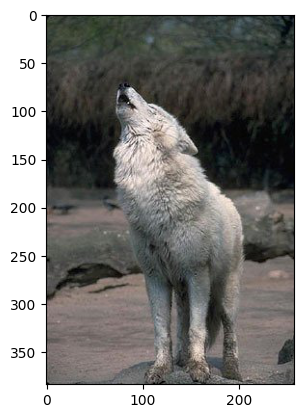

In [155]:
show_class_img(base_set, 24)

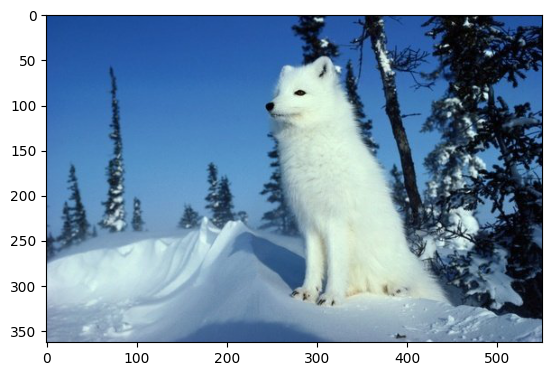

In [156]:
show_class_img(base_set, 26)

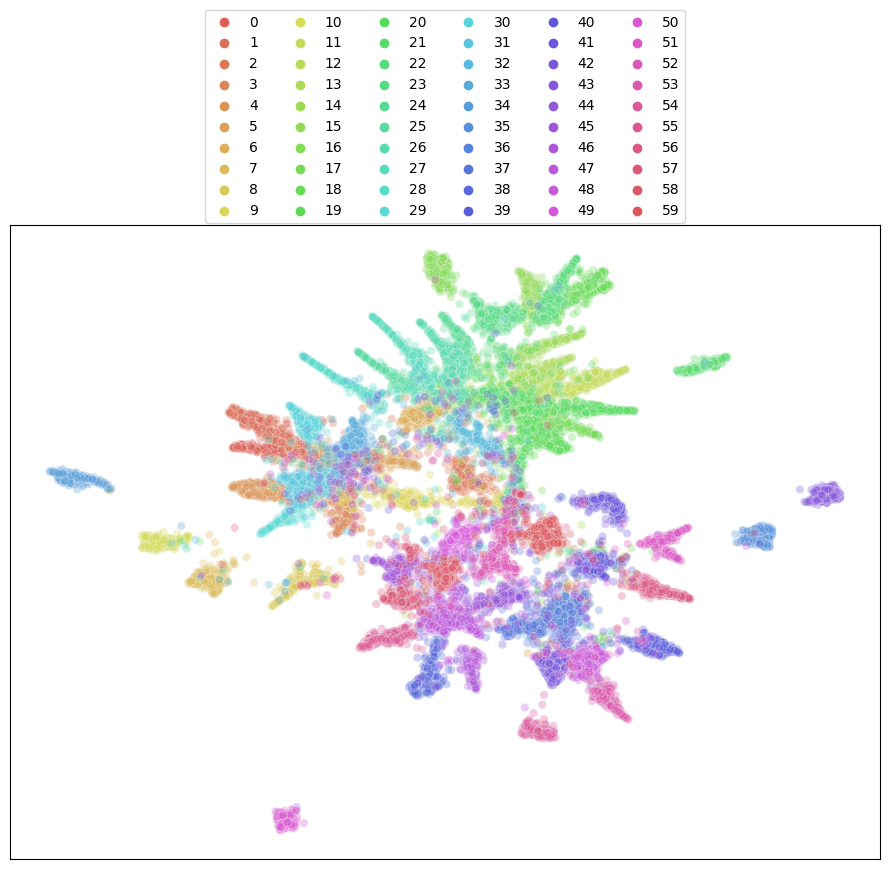

In [504]:
vis_umap(embedding_list, labels_list)

## CUB200

In [520]:
args.dataset = "cub200"
args.sup_con_feat_dim = 512

MYNET = importlib.import_module('models.%s.Network' % ("base_supcon_multi")).MYNET
helper = importlib.import_module('models.%s.helper' % ("base_supcon_multi"))

args = set_up_datasets(args)

model = MYNET(args, mode=args.base_mode, writer = None)
model = nn.DataParallel(model, list(range(args.num_gpu)))
model = model.cuda()

cub_model_dir = "checkpoint/cub200/base_mixup_contrastive_sr/baseline6.0-mixup-joint_label_smoothing_test+1024_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.78.pth"
best_model_dict = load_model(model, cub_model_dir)

In [107]:
base_set, base_trainloader, base_testloader = get_base_dataloader(args)

model.load_state_dict(best_model_dict, strict = True)

In [109]:
# Get prototypes
out = helper.get_base_fc(base_set, base_testloader.dataset.transform, model, args, return_embeddings=True)

best_prototypes_cub = out[0]

embedding_list = out[1]
labels_list = out[2]

Generating Features: : 100%|████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.79it/s]


[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.393588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.730324
[t-SNE] KL divergence after 300 iterations: 0.338646


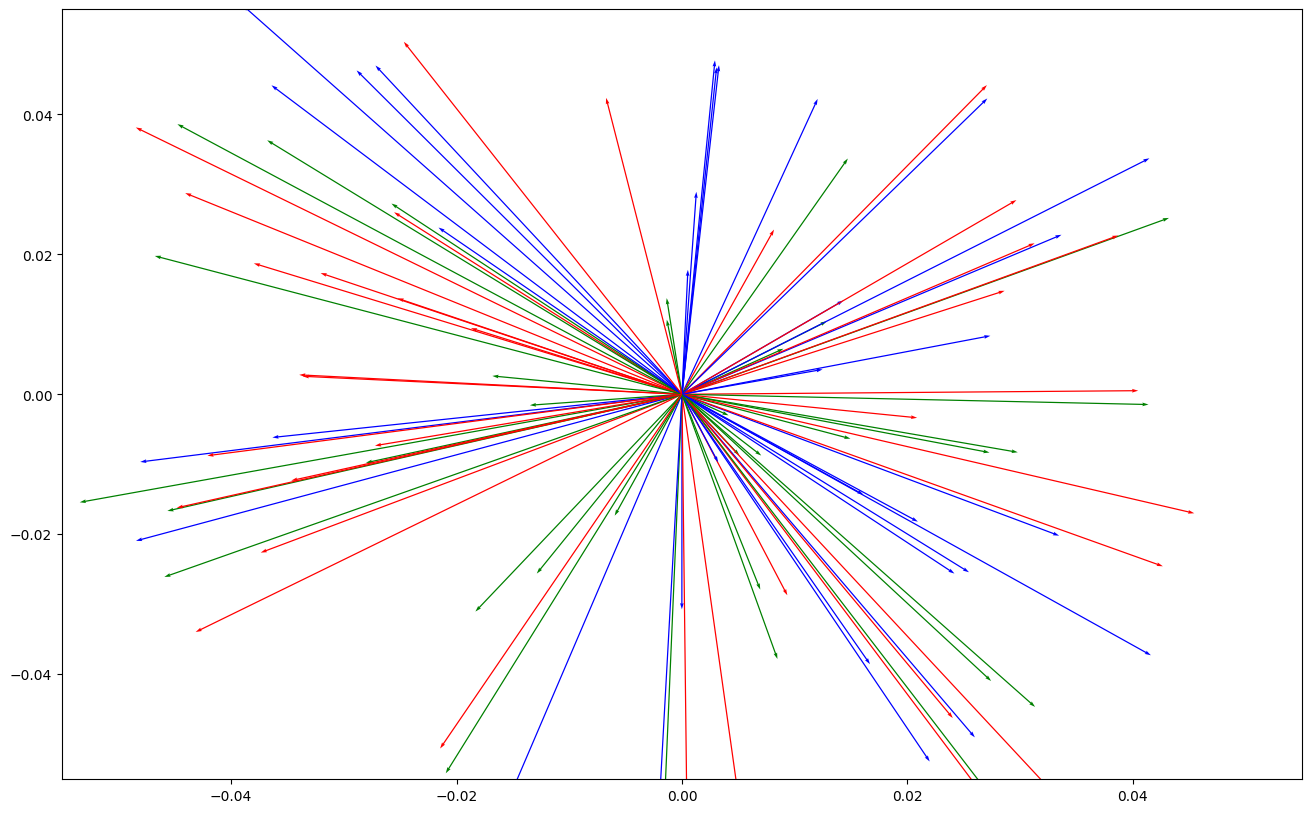

In [112]:
vis_prototypes(best_prototypes_cub)

In [14]:
compute_average_cosine_sim(best_prototypes_cub)

Average prototype cosine similarity: 0.5884699821472168


In [15]:
test(model, best_prototypes_cub, base_testloader)

Base Class Validation Accuracy =  0.7769180834293365


In [16]:
compute_knn_score(embedding_list, labels_list, model, base_testloader)

Computing Embeddings: : 100%|████████████████████████████████████████████| 29/29 [00:03<00:00,  8.72it/s]


Base Class Validation Accuracy usign KNN: 73.394


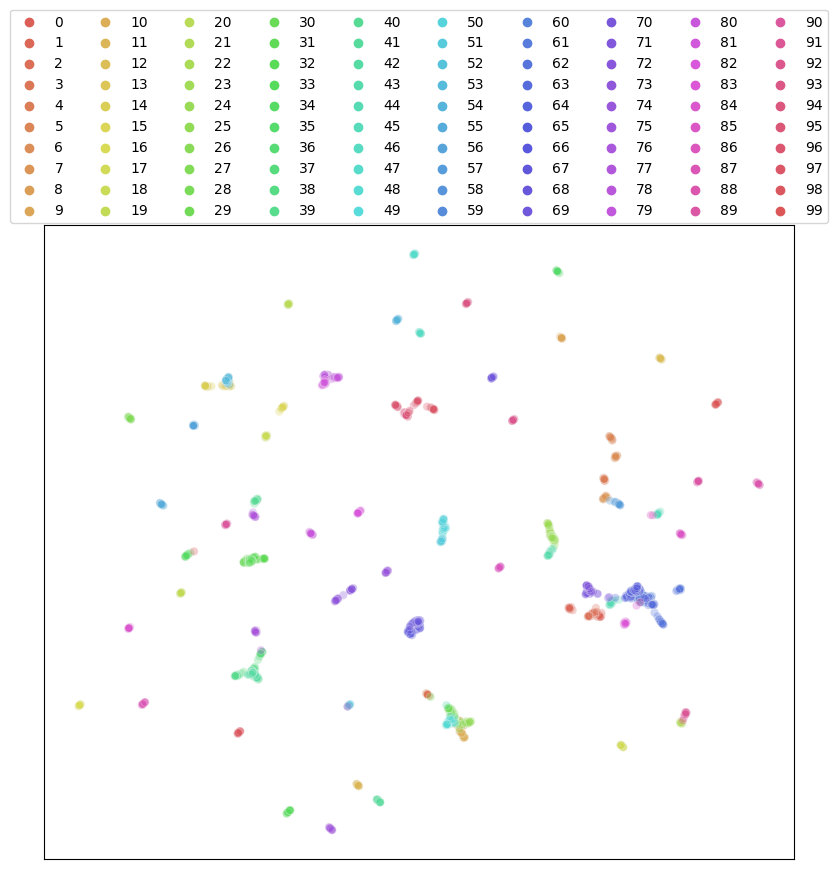

In [37]:
vis_umap(embedding_list, labels_list)

In [238]:
def average_min_angle(prototype):
    proto = prototype.cpu().numpy()  

    # Dot product
    dot = np.matmul(proto, proto.T)
    dot = dot.clip(min=0, max=1)
    
    # Angles
    theta = np.arccos(dot)
    
    # Remove the diagonal
    np.fill_diagonal(theta, np.nan)
    theta = theta[~np.isnan(theta)].reshape(theta.shape[0], theta.shape[1] - 1)
    
    # Average angle with all other prototypes
    avg_angle = theta.mean()
    
    # Avergae angle with closest neighbour
    avg_angle_close = theta.min(axis = 1).mean()
    
    print("Average angle with all other prototypes (deg): ", np.rad2deg(avg_angle))
    print("Average angle with closest prototype (deg): ", np.rad2deg(avg_angle_close))

In [239]:
average_min_angle(best_prototypes_cub)

Average angle with all other prototypes (deg):  53.58145
Average angle with closest prototype (deg):  28.271812


In [240]:
average_min_angle(best_prototypes_minet)

Average angle with all other prototypes (deg):  68.67399
Average angle with closest prototype (deg):  48.41642


# Visualise logit map

In [652]:
# We want to visualise the logit map distribution. I.e. for each class we show average logit distribution and visualise it on a graph 
# separated visually by base and novel classes. This we use to see the effect of novel classes. 

In [653]:
# Compare novel session with 2 methods:
# 1 with bnce loss
# 2 without bnce loss

In [654]:
# We do this for a model only after the first incremental session

In [655]:
# Load cub200

args.dataset = "cub200"
args.sup_con_feat_dim = 512

MYNET = importlib.import_module('models.%s.Network' % ("base_supcon_multi")).MYNET
helper = importlib.import_module('models.%s.helper' % ("base_supcon_multi"))

args = set_up_datasets(args)

model = MYNET(args, mode=args.base_mode, writer = None)
model = nn.DataParallel(model, list(range(args.num_gpu)))
model = model.cuda()

cub_model_dir = "checkpoint/cub200/base_mixup_contrastive_sr/baseline6.0-mixup-joint_label_smoothing_test+1024_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.78.pth"
best_model_dict = load_model(model, cub_model_dir)

Loading init parameters from: checkpoint/cub200/base_mixup_contrastive_sr/baseline6.0-mixup-joint_label_smoothing_test+1024_ft_dot-ft_dot-data_init-start_1/Epo_100-Lr_0.1000-Step_40-Gam_0.10-Bs_128-Mom_0.90-ftLR_0.100-ftnEpoch_60-jEpoch_100-opt_sgd-vm_hm-ls_0.00-ma_0.30/session_pretrain_acc_0.78.pth


In [656]:
# Base Session loading + base prototype generation
base_set, base_trainloader, base_testloader = get_base_dataloader(args)
model.load_state_dict(best_model_dict, strict = True)
out = helper.get_base_fc(base_set, base_testloader.dataset.transform, model, args, return_embeddings=True)
best_prototypes_cub = out[0]
model.module.fc.classifiers[0].weight.data = best_prototypes_cub
best_model_dict = deepcopy(model.state_dict())
# embedding_list = out[1]
# labels_list = out[2]

Generating Features: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.48it/s]


In [659]:
trainset, trainloader, testloader = get_new_dataloader(args, session = 1)
# Random init + with novel session
args.not_data_init = True
args.skip_novel = True
model.load_state_dict(best_model_dict, strict = True)
model.module.update_fc(trainloader, testloader, np.unique(trainset.targets), 1)

In [ ]:
trainset, trainloader, testloader = get_new_dataloader(args, session = 1)
# Avg init + with Novel Session
args.proto_method == "mean"
args.not_data_init = False
args.skip_novel = False
model.load_state_dict(best_model_dict, strict = True)
args.not_data_init = True
model.module.update_fc(trainloader, testloader, np.unique(train_set.targets), session)

In [ ]:
# GM init + with Novel Session

In [660]:
def draw_logit_map_dist(model, n, args, session="base"):
    if session == "base":
        trainset, trainloader, testloader = get_base_dataloader(args)
        classes = torch.arange(args.base_class)
    elif session == "novel":
        # Get first session novel classes
        sess = 1
        trainset, trainloader, testloader = get_new_dataloader(args, session = sess)
        assert n > args.way, print("n must be smaller than then number of shots in the incremental session")
        classes = torch.arange(args.base_class, args.base_class + args.way * sess)
    
    # Sample the classes
    sampled_classes = (classes[torch.randperm(classes.shape[0])])[:n]
    
    # Now for these sampled classes get the logits
    logits_list = []
    label_list = []
    with torch.no_grad():
        tqdm_gen = tqdm(trainloader)
        for _, batch in enumerate(tqdm_gen, 1):
            data, label = [_.cuda() for _ in batch]
            
            # Filtered_idxs
            idxs = torch.argwhere(torch.isin(label, sampled_class.cuda()))
                
            # Skip if no indices this batch for the sampled class
            if idxs.numel() == 0:
                continue
            
            label = label[idxs]
            data = data[idxs]            
            
            # Get logits for all classes up until the 
            embedding = model.module.encode(data)
            logits = model.module.fc.get_logits(embedding)
            
            # Filter our the required labels
            logits_list.append(logits.cpu())
            label_list.append(label.cpu())
        logits_list = torch.cat(logits_list, dim=0)
        label_list = torch.cat(label_list, dim=0)
        
    # Now visualise the logits
    # Average logits for each class
    class_wise_logits = []
    avg_labels = []
    for index in range(args.base_class):
        class_index = (label_list == index).nonzero()
        logits_this = logits_list[class_index.squeeze(-1)]
        logits_this = logits_this.mean(0, keepdims=True).cuda()
        cls_wise_logits.append(logits_this)
        avg_labels.append(index)
        
    class_wise_logits = np.array(class_wise_logits)

    # Generate colors for each row
    colors = np.arange(len(class_wise_logits))

    # Plotting
    for i, row in enumerate(matrix):
        plt.plot(row, c=plt.cm.rainbow(colors[i]))
        plt.text(len(row)-1, row[-1], avg_labels[i], ha='right', va='bottom')

    plt.xlabel('Classes')
    plt.ylabel('Logits')
    plt.title('Logit distribution plot')
    plt.colorbar(label='Class')
    plt.show()

In [662]:
draw_logit_map_dist(model, 3, args, session="base")

  0%|                                                                                                                                                                                                                                         | 0/24 [00:24<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 1, 3, 224, 224]

# Visualise ALICE feature space

In [436]:
from models.alice_model import model_factory

In [437]:
args.arch = "resnet18"
args.no_projector = False
args.feat_dim = 2048
args.num_proj_layers = 2
args.data_fusion = True
args.data_transform = True

model = model_factory.Model(args, pretrained=False)

In [438]:
# checkpoint_fp = "/BS/fscil/work/code/FSCIL_ALICE/test_exp/1/trial1_session0_best.pth"
checkpoint_fp = "/BS/fscil/work/code/FSCIL_ALICE/test_exp/1/trial1_session0_ckpt_epoch_100.pth"
def load_checkpoint(model, filename):
    checkpoint = torch.load(filename, map_location='cuda:0')
#     start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    return model
model = load_checkpoint(model, checkpoint_fp)

In [439]:
model = model.cuda()

In [440]:
base_set, base_trainloader, base_testloader = get_base_dataloader(args)

In [441]:
embedding_list = []
label_list = []
with torch.no_grad():
    tqdm_gen = tqdm(base_trainloader)
    for _, batch in enumerate(tqdm_gen, 1):
        data, label = [_.cuda() for _ in batch]
        embedding = model(data)
        embedding_list.append(embedding.cpu())
        label_list.append(label.cpu())
    embedding_list = torch.cat(embedding_list, dim=0)
    label_list = torch.cat(label_list, dim=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:22<00:00, 10.60it/s]


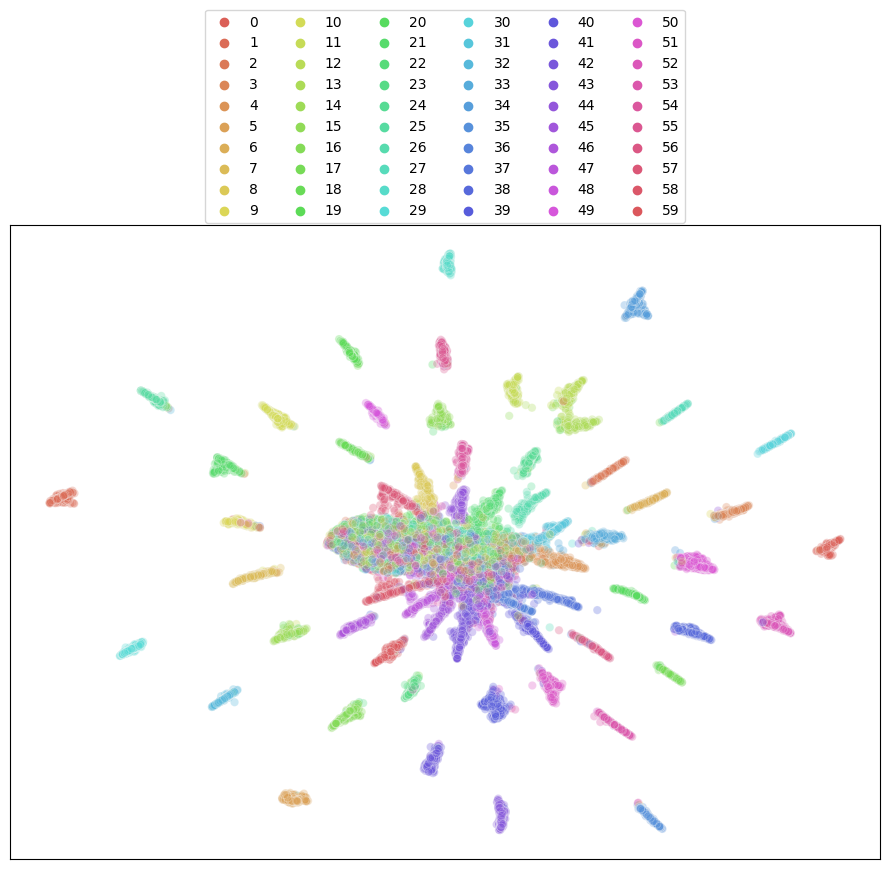

In [385]:
vis_umap(embedding_list, label_list)

In [442]:
# generate the average feature with all data
avg_cls = []
cls_wise_feature_prototype = []
for index in range(args.base_class):
    class_index = (label_list == index).nonzero()
    embedding_this = embedding_list[class_index.squeeze(-1)]
    embedding_this = embedding_this.mean(0, keepdims=True).cuda()
    cls_wise_feature_prototype.append(embedding_this)
    avg_cls.append(index)
    
for i in range(len(cls_wise_feature_prototype)):
    cls_wise_feature_prototype[i] = cls_wise_feature_prototype[i].view(-1)
proto_list = torch.stack(cls_wise_feature_prototype, dim=0).cpu()
best_prototypes_minet_alice = torch.nn.functional.normalize(proto_list, p=2, dim=-1)

In [444]:
print('acquiring feature prototype for testing data ...')
validation_embedding_list = []
validation_label_list = []
with torch.no_grad():
    tqdm_gen = tqdm(base_testloader)
    for _, batch in enumerate(tqdm_gen, 1):
        data, label = [_.cuda() for _ in batch]
        embedding = model(data)
        validation_embedding_list.append(embedding.cpu())
        validation_label_list.append(label.cpu())
validation_embedding_list = torch.cat(validation_embedding_list, dim=0).cpu()
# validation_embedding_list = torch.nn.functional.normalize(validation_embedding_list, p=2, dim=-1)

validation_label_list = torch.cat(validation_label_list, dim=0).cpu()

acquiring feature prototype for testing data ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.17it/s]


In [391]:
logits= nn.functional.linear(validation_embedding_list,best_prototypes_minet_alice)
pred = torch.argmax(logits, dim=1)
(pred == validation_label_list).type(torch.FloatTensor).mean().item()

0.10883333534002304

[Text(0.5, 47.7222222222222, 'Predicted Classes'),
 Text(120.72222222222221, 0.5, 'True Classes'),
 Text(0.5, 1.0, 'Base Classes')]

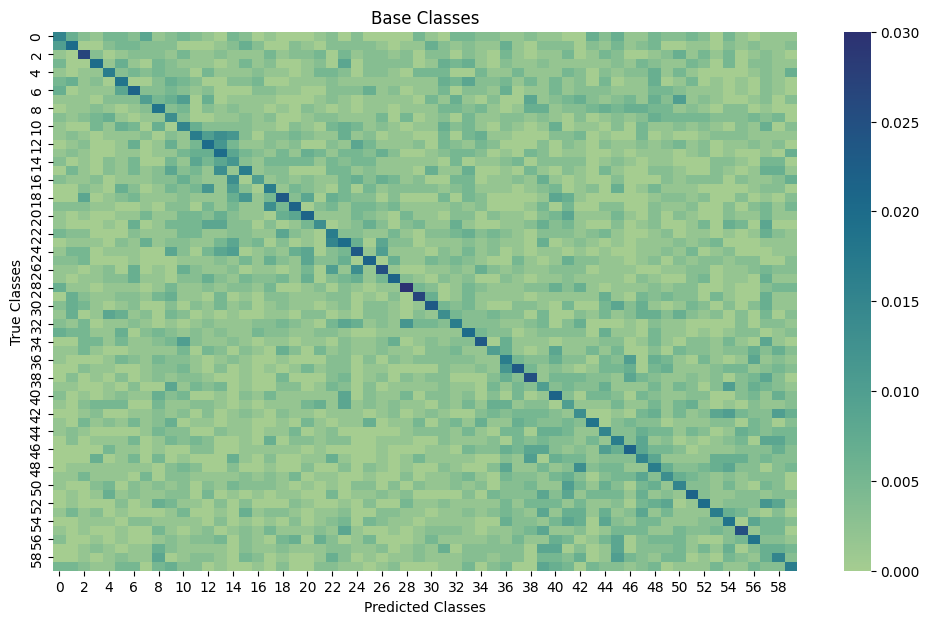

In [445]:
cf_matrix = confusion_matrix(validation_label_list, pred)
classes = validation_label_list.unique().numpy()

# Visualize confusion matrix
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(df_cm, annot=False, cmap = "crest")

heatmap.set(xlabel="Predicted Classes", ylabel="True Classes", title=f"Base Classes")